# Performative Prediction with Neural Networks: A Case Study in Strategic Classification

This notebook replicates the main experiments in the Performative Prediction with Neural Networks paper by Mehrnaz Mofakhami, Ioannis Mitliagkas, and Gauthier Gidel.

The code is based on: https://github.com/mrtzh/whynot/tree/master/examples/dynamic_decisions

In [1]:
# whynot == 0.11.0
# gym == 0.23.0

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import sys
# sys.path.append('/Users/mehrnaz/Documents/uni/Mila/Research Readings/Performative Prediction/Whynot code/whynot')
import whynot as wn
import whynot.gym as gym
%matplotlib inline
import time
import seaborn as sns

/home/pedramkh/PerformativePrediction/pp_venv/lib/python3.9/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


## Setting up the strategic classification environment

We use the [credit simulator](https://whynot.readthedocs.io/en/latest/simulators.html#credit-simulator), which is a strategic classification simulator based on the Kaggle [*Give Me Some Credit* dataset](https://www.kaggle.com/c/GiveMeSomeCredit).

In [3]:
env = gym.make('Credit-v0')
env.seed(1)

[1]

## Training a baseline logistic regression classifier

The state of the environment is a dataset consisting of (1) financial features of individuals, e.g. `DebtRatio`, and (2) a binary label indicating whether an individual experienced financial distress in the subsequent two years. 

In [4]:
base_dataset = env.initial_state.values()
base_features, base_labels = base_dataset["features"], base_dataset["labels"]
num_agents, num_features = base_features.shape
print(f"The dataset has {num_agents} agents and {num_features} features.")

The dataset has 18357 agents and 11 features.


Fit a logistic regression model to the data

## RRM with Resample-if-Rejected procedure 

In [5]:
import scripts.utils_torch as utils_torch
import torch
import torch.optim as optim
import copy

In [6]:
def forward(features, model):
    features_t = torch.from_numpy(features)
    with torch.no_grad():
        y_hat = model(features_t)
    return y_hat.numpy()

def accuracy(preds, epsilon, labels):
    return ((preds > (1-epsilon)/2.0)*(1.0-epsilon) == labels).mean()

### Modelling Distribution Shift

In [7]:
def agent_shift(features, mode, model = None):
    
    """Compute agent response to the classifier and adapt features accordingly.
    """
    
    if mode == 'default':
        # Move everything by epsilon in the direction towards better classification
        
        strategic_features = np.copy(features)
        theta_strat = config.theta[config.changeable_features].flatten()
        strategic_features[:, config.changeable_features] -= config.epsilon * theta_strat
        return strategic_features
    
    elif mode == 'case1': # W1 counterexample
        strategic_features = np.copy(features)    
        strategic_features[:,0] = (np.tanh(model.theta[0])+2) * model.epsilon
        return strategic_features
    
    elif mode == 'RS': # RIR procedure

        preds = forward(features, model)
#         print(f'preds:{preds}')
        n = features.shape[0]
        r = np.random.uniform(0,1,(n,))
        resample_indices = np.random.randint(0,n,(n,))
        new_indices = np.where(r < (preds+model.epsilon), resample_indices, np.arange(n))

        strategic_features = features[:,env.config.changeable_features]
        new_strategic_features = strategic_features[new_indices]
        new_features = np.copy(features)
        new_features[:, env.config.changeable_features] = new_strategic_features

        return new_features
        
    

### Repeated Risk Minimization

In [8]:
def tensor_repeated_risk_minimization(epsilon, learning_rate, num_iters, l2_penalty, mode, layers, method, hidden_size = 8):
    """Run repeated risk minimization for num_iters steps"""
    env.config.epsilon = epsilon
    env.config.l2_penalty = l2_penalty
    env.config.mode = mode

    assert method in ['tail_averaging', 'duo_averaging', 't_averaging', 'last_iterate']
    # Track loss and accuracy before/after updating model on new distribution
    loss_start, loss_end, acc_start, acc_end, theta_gaps, f_theta_gaps = [], [], [], [], [], []
    
    if layers==1:
        model = utils_torch.onelayer_NN(epsilon, mode)
    else:
        model = utils_torch.twolayers_NN(epsilon, mode, hidden_size)
        
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    base_dataset = env.initial_state.values()
    base_features, base_labels = base_dataset["features"], base_dataset["labels"]
    base_labels = base_labels.astype('float64')
    base_labels[base_labels==1]=1.0-epsilon

    base_features_t = torch.from_numpy(base_features)
    base_labels_t = torch.from_numpy(base_labels)


    eval_bool = False
    utils_torch.fit_logistic_regression(base_features_t, base_labels_t, l2_penalty, model, optimizer, eval_bool, mode = mode)
    
    preds = forward(base_features, model)
    base_acc = accuracy(preds, epsilon, base_labels)
    # print(f'BASE ACCURACY:{base_acc}')
    
    M = 0.0
    features_recorder = [torch.from_numpy(base_features)]
    
    labels = np.copy(base_labels)
    
    for step in range(num_iters):
        
        
        # Deploy classifier and observe strategic response
        ''' From the first step strategic behavior is applied so it differs for different values of epsilon '''
          
        features_start = agent_shift(base_features, mode, model)

        # Evaluate loss and accuracy on the new distribution
        features_start_t = torch.from_numpy(features_start)
        labels_t = torch.from_numpy(labels)

        eval_bool = True
        loss_start.append(
            utils_torch.evaluate_logistic_loss(features_start_t, labels_t, l2_penalty, model, eval_bool, mode = mode).item())
        eval_bool = False
        
        preds = forward(features_start, model)

        theta_list = []
        with torch.no_grad():
            for weight in model.parameters():
                theta_list.append(weight.detach().clone().numpy())
                
        start_acc = accuracy(preds, epsilon, labels)
        acc_start.append(start_acc)
        # if step % 5 == 0:
            # print(f'iteration:{step}, start_accuracy:{start_acc}')


        M = np.maximum(M, np.max(np.abs(preds - labels)))
        
        # Recording the features
        features_recorder.append(torch.from_numpy(features_start))
        
        # Learn a new model on the induced distribution
        if method == 'last_iterate':
            training_features = features_recorder[-1]
            training_labels = torch.from_numpy(labels)
        elif method == 'duo_averaging':
            training_features = torch.cat((features_recorder[-2], features_recorder[-1]), dim=0)
            training_labels = torch.cat((labels_t, labels_t), dim=0)
        elif method == 't_averaging':
            training_features = torch.cat(features_recorder, dim=0)
            training_labels = torch.cat([labels_t]*len(features_recorder), dim=0)
        
        utils_torch.fit_logistic_regression(training_features, training_labels, l2_penalty, model, optimizer, eval_bool, mode = mode)
        
        # Evaluate loss and accuracy on the strategic distribution after training
        eval_bool = True
        loss_end.append(
            utils_torch.evaluate_logistic_loss(features_start_t, labels_t, l2_penalty, model, eval_bool, mode = mode).item()
        )
        eval_bool = False
        
        predss = forward(features_start, model)
        end_acc = accuracy(predss, epsilon, labels)

        # if step % 5 == 0:
        #     print(f'iteration:{step}, end_accuracy:{end_acc}')
        acc_end.append(end_acc)
        
        theta_new_list = []
        with torch.no_grad():
            for weight in model.parameters():
                theta_new_list.append(weight.detach().clone().numpy())
          
        theta_gap = 0
        for i in range(len(theta_list)):
            theta_gap += np.linalg.norm(theta_list[i]-theta_new_list[i])
            
            
        theta_gaps.append(theta_gap)
            

        # Track distance between iterates
        f_theta_gap = np.sqrt(np.mean((preds - predss)**2))
        f_theta_gaps.append(f_theta_gap)
        
    return loss_start, loss_end, acc_start, acc_end, theta_gaps, f_theta_gaps

### Training - single $\delta$

In [ ]:
delta_list = [0.9]
num_iters = 30
mode = 'RS' # Resample-if-Rejected
layers = 2
l2_penalty = 1.0
learning_rates = [3e-4,3e-4,3e-4,3e-4]
method_list = ['duo_averaging', 't_averaging', 'last_iterate']  # Add your methods here

results = {}

start_time = time.time()
for method in method_list:
    results[method] = {
        'loss_starts': [],
        'acc_starts': [],
        'loss_ends': [],
        'acc_ends': [],
        'theta_gaps': [],
        'f_gaps': []
    }
    for epsilon_idx, epsilon in enumerate(delta_list):
        print(f"Running retraining for epsilon {1/epsilon - 1:.2f} with method {method}")
        learning_rate = learning_rates[epsilon_idx]
        loss_start, loss_end, acc_start, acc_end, theta_gap, f_theta_gaps = tensor_repeated_risk_minimization(epsilon, learning_rate, num_iters, l2_penalty, mode, layers, method=method)
        results[method]['loss_starts'].append(loss_start)
        results[method]['loss_ends'].append(loss_end)
        results[method]['acc_starts'].append(acc_start)
        results[method]['acc_ends'].append(acc_end)
        results[method]['theta_gaps'].append(theta_gap)
        results[method]['f_gaps'].append(f_theta_gaps)
total_time = time.time() - start_time

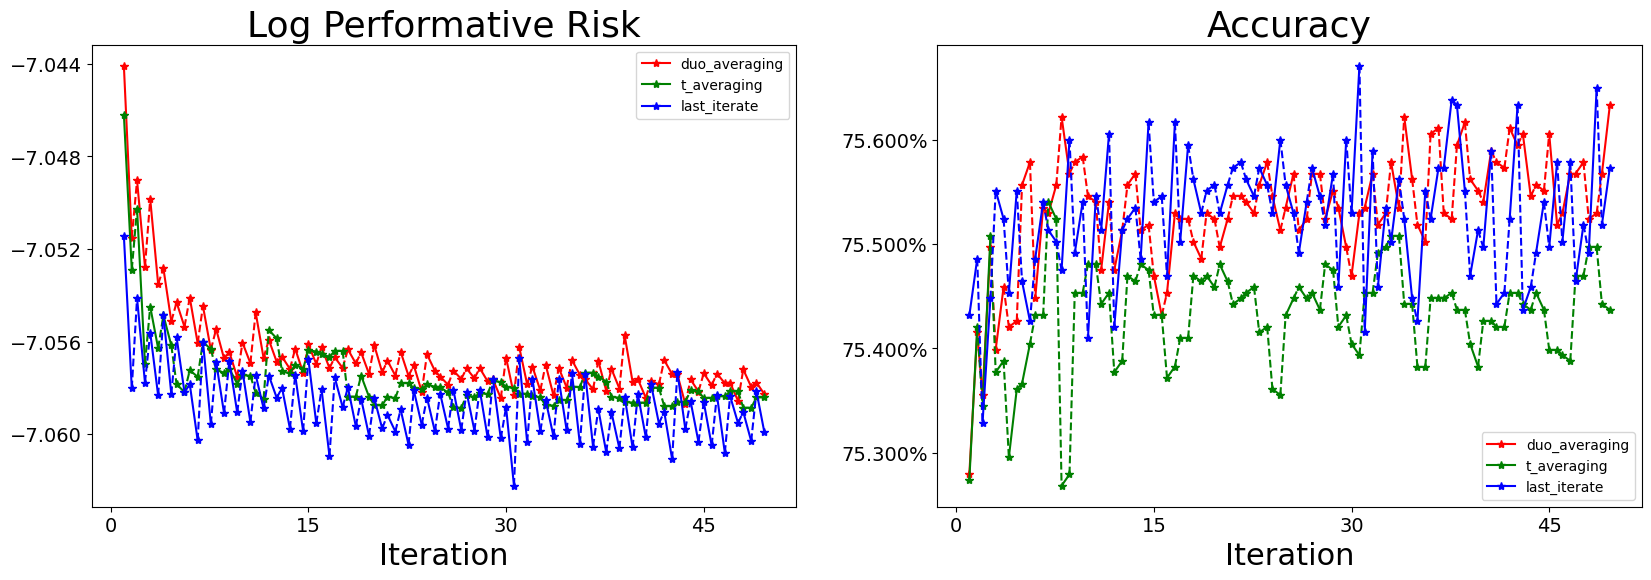

In [14]:
import matplotlib.ticker as mtick
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Define colors for each method
colors = {'duo_averaging': 'r', 't_averaging': 'g', 'last_iterate': 'b'}

loading_dir = '/home/pedramkh/PerformativePrediction/Performative-Prediction-with-Neural-Networks/results_directory/results_delta_0.9_40runs.pkl'
load_data = False
if load_data:
    with open(loading_dir, 'rb') as f:
        results = pickle.load(f)


for method in method_list:
    ax = axes[0]
    offset = 0.6

    # Get data from results dictionary
    loss_starts = results[method]['loss_starts']
    loss_ends = results[method]['loss_ends']
    acc_starts = results[method]['acc_starts']
    acc_ends = results[method]['acc_ends']

    loss_starts_log = np.log(np.array(loss_starts))
    loss_ends_log = np.log(np.array(loss_ends))
    ax.set_title("Log Performative Risk", fontsize=26)
    for i in range(1, num_iters):  # Start from second iteration
        ax.plot([i,i + offset],[loss_starts_log[0][i], loss_ends_log[0][i]],'-*', color=colors[method], label=method if i == 1 else "")
        if i < num_iters - 1:
            ax.plot([i + offset, i + 1],[loss_ends_log[0][i], loss_starts_log[0][i + 1]],'--', color=colors[method])
    ax.set_xlabel("Iteration", fontsize=22)
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.tick_params(axis='both', labelsize=14)
    plt.rcParams['ytick.labelsize']=14

    ax = axes[1]
    offset = 0.6
    acc_starts_np = np.array(acc_starts) * 100
    acc_ends_np = np.array(acc_ends) * 100
    ax.set_title("Accuracy", fontsize=26)
    for i in range(1, num_iters):  # Start from second iteration
        ax.plot([i,i + offset],[acc_starts_np[0][i], acc_ends_np[0][i]],'-*', color=colors[method], label=method if i == 1 else "")
        if i < num_iters - 1:
            ax.plot([i + offset, i + 1],[acc_ends_np[0][i], acc_starts_np[0][i + 1]],'--', color=colors[method])
    ax.set_xlabel("Iteration", fontsize=22)
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.tick_params(axis='both', labelsize=14)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

axes[0].legend()
axes[1].legend()
plt.subplots_adjust(hspace=0.25)
# fig.savefig('./Results/Run2/result.png', dpi=300)

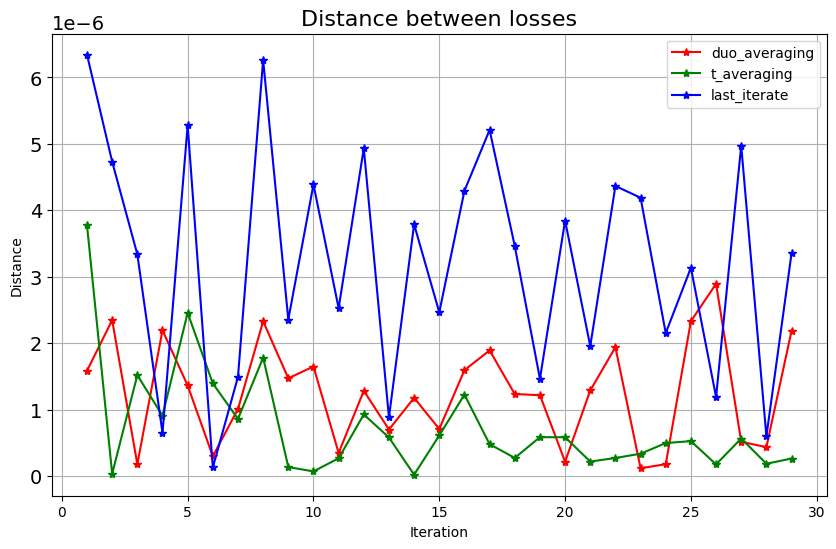

In [19]:
import matplotlib.pyplot as plt

# Define colors for each method
colors = {'duo_averaging': 'r', 't_averaging': 'g', 'last_iterate': 'b'}

plt.figure(figsize=(10, 6))

for method in method_list:
    # Calculate distances
    distances = [abs(results[method]['loss_ends'][0][i] - results[method]['loss_starts'][0][i + 1]) for i in range(len(results[method]['loss_ends'][0]) - 1)]
    
    # Plot distances
    plt.plot(range(1, len(distances) + 1), distances, marker='*', linestyle='-', color=colors[method], label=method)

plt.title('Distance between losses', fontsize=16)
plt.xlabel('Iteration')
plt.ylabel('Distance')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each method
colors = {'duo_averaging': 'b', 't_averaging': 'g', 'last_iterate': 'r'}

for method in method_list:
    # Get data from results dictionary
    theta_gaps = results[method]['theta_gaps'][0][:30]

    # Plot theta_gaps
    ax.plot(theta_gaps,'-*', color=colors[method], label=method)

ax.set_title("Theta Gaps", fontsize=26)
ax.set_xlabel("Iteration", fontsize=22)
ax.tick_params(axis='both', labelsize=14)
plt.rcParams['ytick.labelsize']=14

ax.legend()
plt.show()

### Theta Gaps

In [10]:
import numpy as np
import time

nruns_ = 40  # Set the number of runs

delta_list = [0.55]
num_iters = 50
mode = 'RS'  # Resample-if-Rejected
layers = 2
l2_penalty = 1.0
learning_rates = [3e-4,3e-4,3e-4,3e-4]
method_list = ['duo_averaging', 't_averaging', 'last_iterate']  # Add your methods here

results = {}

start_time = time.time()
for run in range(nruns_):
    print(f"Run {run + 1} of {nruns_}")
    for method in method_list:
        if run == 0:
            results[method] = {
                'loss_starts': [],
                'acc_starts': [],
                'loss_ends': [],
                'acc_ends': [],
                'theta_gaps': [],
                'f_gaps': []
            }
        for epsilon_idx, epsilon in enumerate(delta_list):
            print(f"Running retraining for epsilon {1/epsilon - 1:.2f} with method {method}")
            learning_rate = learning_rates[epsilon_idx]
            loss_start, loss_end, acc_start, acc_end, theta_gap, f_theta_gaps = tensor_repeated_risk_minimization(epsilon, learning_rate, num_iters, l2_penalty, mode, layers, method)
            
            results[method]['loss_starts'].append(loss_start)
            results[method]['loss_ends'].append(loss_end)
            results[method]['acc_starts'].append(acc_start)
            results[method]['acc_ends'].append(acc_end)
            results[method]['theta_gaps'].append([theta_gap])
            results[method]['f_gaps'].append(f_theta_gaps)

total_time = time.time() - start_time

Run 1 of 40
Running retraining for epsilon 0.82 with method duo_averaging
Running retraining for epsilon 0.82 with method t_averaging
Running retraining for epsilon 0.82 with method last_iterate
Run 2 of 40
Running retraining for epsilon 0.82 with method duo_averaging
Running retraining for epsilon 0.82 with method t_averaging
Running retraining for epsilon 0.82 with method last_iterate
Run 3 of 40
Running retraining for epsilon 0.82 with method duo_averaging
Running retraining for epsilon 0.82 with method t_averaging
Running retraining for epsilon 0.82 with method last_iterate
Run 4 of 40
Running retraining for epsilon 0.82 with method duo_averaging
Running retraining for epsilon 0.82 with method t_averaging
Running retraining for epsilon 0.82 with method last_iterate
Run 5 of 40
Running retraining for epsilon 0.82 with method duo_averaging
Running retraining for epsilon 0.82 with method t_averaging
Running retraining for epsilon 0.82 with method last_iterate
Run 6 of 40
Running retra

In [11]:
# Create a directory to save the results
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

path = "results_directory"
os.makedirs(path, exist_ok=True)

# Save the results dictionary to a file in the created directory
with open(os.path.join(path, 'results_delta_0.55_40runs.pkl'), 'wb') as f:
    pickle.dump(results, f)

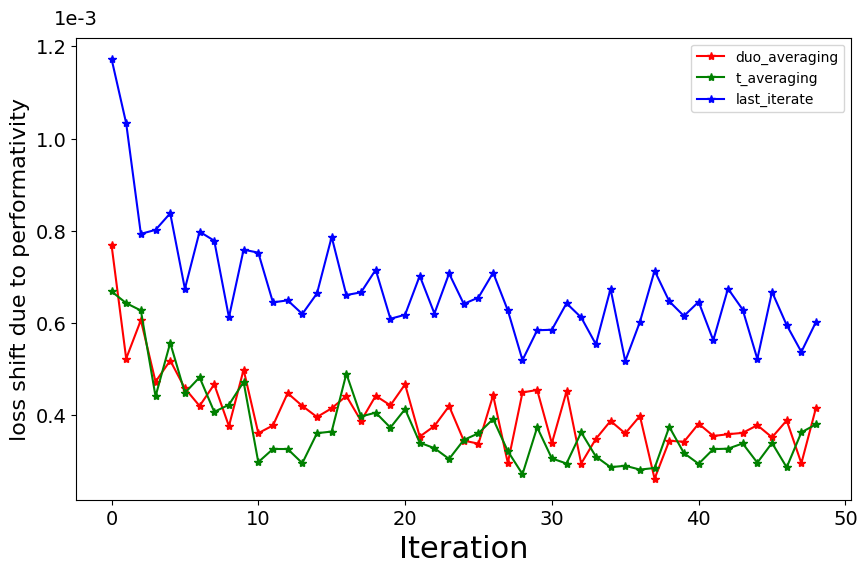

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

fig, ax = plt.subplots(figsize=(10, 6))

loading_dir = '/home/pedramkh/PerformativePrediction/Performative-Prediction-with-Neural-Networks/results_directory/results_delta_0.55_40runs.pkl'
load_data = True
if load_data:
    with open(loading_dir, 'rb') as f:
        results = pickle.load(f)

# Define colors for each method
colors = {'duo_averaging': 'r', 't_averaging': 'g', 'last_iterate': 'b'}
method_list = ['duo_averaging', 't_averaging', 'last_iterate']  # Add your methods here

for method in method_list:
    # Get data from results dictionary
    loss_ends = np.array(results[method]['loss_ends'])
    loss_starts = np.array(results[method]['loss_starts'])
    # Compute the distances for each iteration and run
    distances = np.abs(loss_ends[:, :-1] - loss_starts[:, 1:])
    
# Compute the average distances over runs and scale them
    scaling_factor = 10000  # The scaling factor
    avg_distances = np.mean(distances, axis=0) * scaling_factor
    
    # Compute the natural logarithm of the average distances
    # log_avg_distances = np.log(avg_distances)
    
    # Plot avg_distances with a star marker for each iterate
    ax.plot(avg_distances, '-*', color=colors[method], label=method)

ax.set_ylabel("loss shift due to performativity", fontsize=16)
ax.set_xlabel("Iteration", fontsize=22)
ax.tick_params(axis='both', labelsize=14)
plt.rcParams['ytick.labelsize']=14

# Add the scale factor on top of the y-axis
ax.text(-0.0, 1.02, '1e-3', transform=ax.transAxes, va='bottom', ha='center', fontsize=14)
ax.legend()
plt.savefig('average_loss_gaps_over_epsilons_delta_0.55_40runs_log.png')  # Save the figure
plt.show()

### Hidden layer affects

In [ ]:
import numpy as np
import time
import multiprocessing as mp

def worker(args):
    delta, learning_rate, num_iters, l2_penalty, mode, layers, method, hidden_size = args
    loss_start, loss_end, acc_start, acc_end, theta_gap, f_theta_gaps = tensor_repeated_risk_minimization(delta, learning_rate, num_iters, l2_penalty, mode, layers, method, hidden_size)
    return method, hidden_size, loss_start, loss_end, acc_start, acc_end, theta_gap, f_theta_gaps

nruns_ = 20  # Set the number of runs
hidden_size_list = [8, 16, 32]
num_iters = 50
mode = 'RS'  # Resample-if-Rejected
layers = 2
delta=0.9
l2_penalty = 1.0
learning_rates = [3e-4,3e-4,3e-4,3e-4]
method_list = ['duo_averaging','last_iterate']  # Add your methods here
results = {}
start_time = time.time()

pool = mp.Pool(mp.cpu_count())

for run in range(nruns_):
    print(f"Run {run + 1} of {nruns_}")
    for method in method_list:
        if run == 0:
            results[method] = {}
            for hidden_size in hidden_size_list:
                results[method][hidden_size] = {
                    'loss_starts': [],
                    'acc_starts': [],
                    'loss_ends': [],
                    'acc_ends': [],
                    'theta_gaps': [],
                    'f_gaps': []
                }
        
        args_list = [(delta, learning_rates[hidden_size_idx], num_iters, l2_penalty, mode, layers, method, hidden_size) for hidden_size_idx, hidden_size in enumerate(hidden_size_list)]
        results_list = pool.map(worker, args_list)
        
        for method, hidden_size, loss_start, loss_end, acc_start, acc_end, theta_gap, f_theta_gaps in results_list:
            results[method][hidden_size]['loss_starts'].append(loss_start)
            results[method][hidden_size]['loss_ends'].append(loss_end)
            results[method][hidden_size]['acc_starts'].append(acc_start)
            results[method][hidden_size]['acc_ends'].append(acc_end)
            results[method][hidden_size]['theta_gaps'].append([theta_gap])
            results[method][hidden_size]['f_gaps'].append(f_theta_gaps)

pool.close()
pool.join()

total_time = time.time() - start_time

In [9]:
import numpy as np
import time
nruns_ = 20  # Set the number of runs
hidden_size_list = [8, 16, 32]
num_iters = 31
mode = 'RS'  # Resample-if-Rejected
layers = 2
delta=0.9
l2_penalty = 1.0
learning_rates = [3e-4,3e-4,3e-4,3e-4]
method_list = ['duo_averaging', 'last_iterate']  # Add your methods here
results = {}
start_time = time.time()
for run in range(nruns_):
    print(f"Run {run + 1} of {nruns_}")
    for method in method_list:
        if run == 0:
            results[method] = {}
            for hidden_size in hidden_size_list:
                results[method][hidden_size] = {
                    'loss_starts': [],
                    'acc_starts': [],
                    'loss_ends': [],
                    'acc_ends': [],
                    'theta_gaps': [],
                    'f_gaps': []
                }
        
        for hidden_size_idx, hidden_size in enumerate(hidden_size_list):
            print(f"Running retraining for hidden size {hidden_size} with method {method}")
            learning_rate = learning_rates[hidden_size_idx]
            loss_start, loss_end, acc_start, acc_end, theta_gap, f_theta_gaps = tensor_repeated_risk_minimization(delta, learning_rate, num_iters, l2_penalty, mode, layers, method, hidden_size)
            
            results[method][hidden_size]['loss_starts'].append(loss_start)
            results[method][hidden_size]['loss_ends'].append(loss_end)
            results[method][hidden_size]['acc_starts'].append(acc_start)
            results[method][hidden_size]['acc_ends'].append(acc_end)
            results[method][hidden_size]['theta_gaps'].append([theta_gap])
            results[method][hidden_size]['f_gaps'].append(f_theta_gaps)
total_time = time.time() - start_time

Run 1 of 20
Running retraining for hidden size 8 with method duo_averaging
Running retraining for hidden size 16 with method duo_averaging
Running retraining for hidden size 32 with method duo_averaging
Running retraining for hidden size 8 with method last_iterate
Running retraining for hidden size 16 with method last_iterate
Running retraining for hidden size 32 with method last_iterate
Run 2 of 20
Running retraining for hidden size 8 with method duo_averaging
Running retraining for hidden size 16 with method duo_averaging
Running retraining for hidden size 32 with method duo_averaging
Running retraining for hidden size 8 with method last_iterate
Running retraining for hidden size 16 with method last_iterate
Running retraining for hidden size 32 with method last_iterate
Run 3 of 20
Running retraining for hidden size 8 with method duo_averaging
Running retraining for hidden size 16 with method duo_averaging
Running retraining for hidden size 32 with method duo_averaging
Running retrain

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

# Create a directory to save the results
path = "results_directory"
os.makedirs(path, exist_ok=True)

# Save the results dictionary to a file in the created directory
with open(os.path.join(path, 'results_delta_0.9_20runs_hidden_size.pkl'), 'wb') as f:
    pickle.dump(results, f)

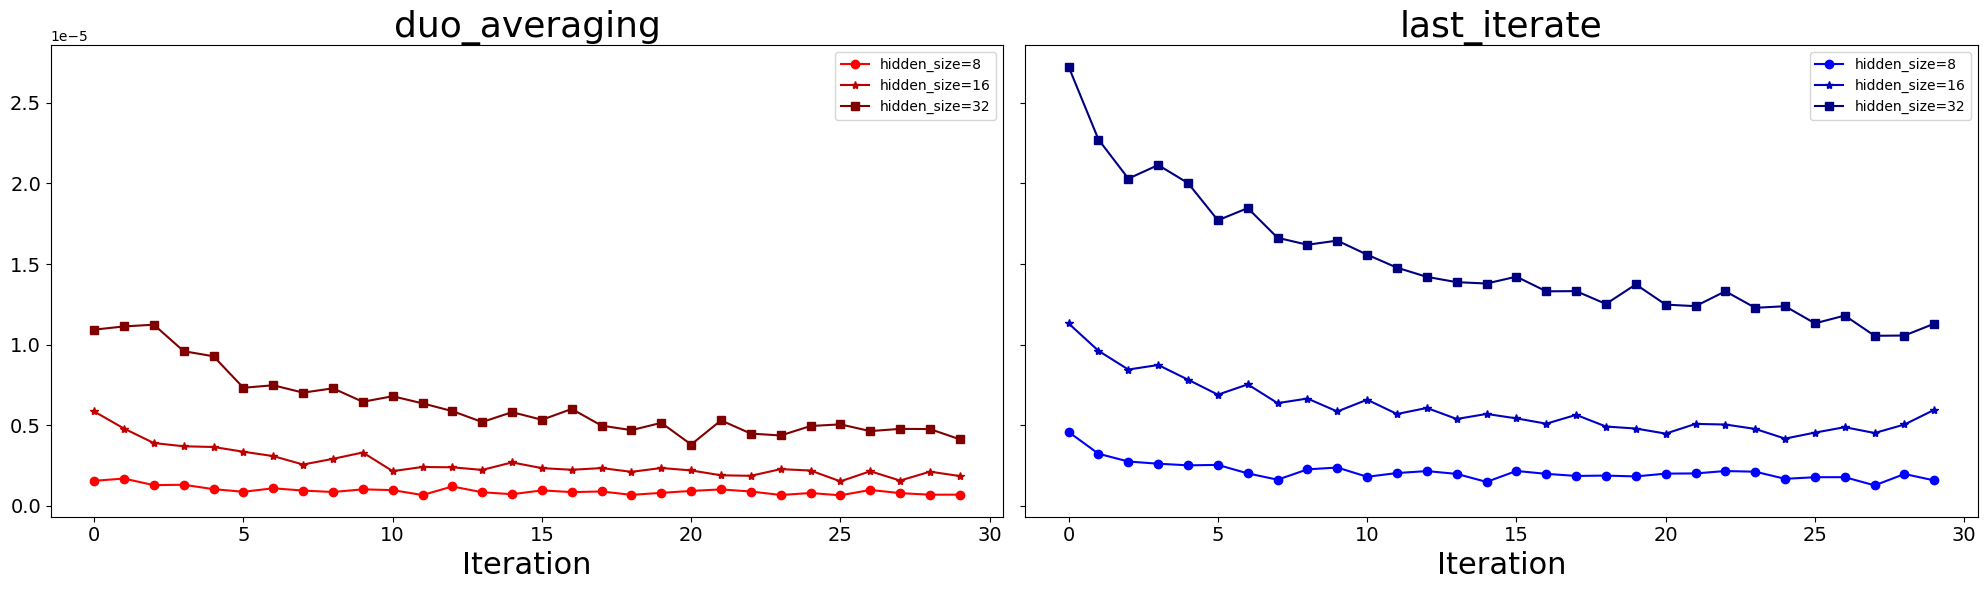

In [14]:
# Define markers and colors for each hidden_size
markers = {8: 'o', 16: '*', 32: 's'}
colors = {8: '#FF0000', 16: '#BF0000', 32: '#800000'}  # Different shades of red
colors_last_iterate = {8: '#0000FF', 16: '#0000BF', 32: '#000080'}  # Different shades of blue

# Create a subplot for each method
fig, axs = plt.subplots(1, len(method_list), figsize=(10 * len(method_list), 6), sharey=True)

for idx, method in enumerate(method_list):
    ax = axs[idx]
    ax.set_title(method, fontsize=26)
    
    for hidden_size in hidden_size_list:
        # Get data from results dictionary
        loss_ends = np.array(results[method][hidden_size]['loss_ends'])
        loss_starts = np.array(results[method][hidden_size]['loss_starts'])
        # Compute the distances for each iteration and run
        distances = np.abs(loss_ends[:, :-1] - loss_starts[:, 1:])
        
        # Compute the average distances over runs
        avg_distances = np.mean(distances, axis=0)
        
        # Plot avg_distances with a specific color and marker for each method and hidden_size
        color = colors[hidden_size] if method == 'duo_averaging' else colors_last_iterate[hidden_size]
        marker = markers[hidden_size]
        ax.plot(avg_distances, linestyle='-', marker=marker, color=color, label=f'hidden_size={hidden_size}')
    
    ax.set_xlabel("Iteration", fontsize=22)
    ax.tick_params(axis='both', labelsize=14)
    ax.legend()

plt.tight_layout()
plt.savefig('average_loss_gaps_over_epsilons_delta_0.9_20runs_hidden_size.png')  # Save the figure
plt.show()

### Visualizing the loss for one $\delta$ value

#### Execute this cell if you have run the training for a single value of $\delta$; it will plot the evolution of Log Performative Risk and Accuracy through iterations of RRM for the specified $\delta$.

In [ ]:
import matplotlib.ticker as mtick

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))  # Changed ncols to 1 and adjusted figsize

offset = 0.6

loss_starts_log_avg = np.mean(np.log(np.array(all_loss_starts)), axis=0)
loss_ends_log_avg = np.mean(np.log(np.array(all_loss_ends)), axis=0)
new_loss_starts_log_avg = np.mean(np.log(np.array(all_new_loss_starts)), axis=0)
new_loss_ends_log_avg = np.mean(np.log(np.array(all_new_loss_ends)), axis=0)
new_loss_starts_log_all_data_avg = np.mean(np.log(np.array(all_new_loss_starts_all_data)), axis=0)
new_loss_ends_log_all_data_avg = np.mean(np.log(np.array(all_new_loss_ends_all_data)), axis=0)

distances = np.log(np.abs(loss_starts_log_avg[:, :-1] - loss_ends_log_avg[:, 1:]))
new_distances = np.log(np.abs(new_loss_starts_log_avg[:, :-1] - new_loss_ends_log_avg[:, 1:]))
new_distances_all_data = np.log(np.abs(new_loss_starts_log_all_data_avg[:, :-1] - new_loss_ends_log_all_data_avg[:, 1:]))

# Plotting the log distance between consecutive losses

axes.set_title("Log Distance between Consecutive Losses", fontsize=26)
for i in range(0, len(distances)):
    axes.plot(distances[i], label=f'Original Distances', color='b')
    axes.scatter(range(len(distances[i])), distances[i], color='b', marker='*')  # Changed points to stars
    axes.plot(new_distances[i], label=f'New Distances', color='r')
    axes.scatter(range(len(new_distances[i])), new_distances[i], color='r', marker='*')  # Changed points to stars
    axes.plot(new_distances_all_data[i], label=f'New Distances All Data', color='k')
    axes.scatter(range(len(new_distances_all_data[i])), new_distances_all_data[i], color='k', marker='*')  # Changed points to stars
axes.set_xlabel("Iteration", fontsize=22)
axes.yaxis.set_major_locator(plt.MaxNLocator(5))
axes.xaxis.set_major_locator(plt.MaxNLocator(4))
axes.tick_params(axis='both', labelsize=14)
axes.legend()
plt.rcParams['ytick.labelsize']=14

plt.subplots_adjust(hspace=0.25)
plt.legend()
plt.show()

### Training - different values of $\delta$

In [ ]:
delta_list = [0.1, 0.4, 0.7, 0.9]
num_iters = 30
mode = 'RS' # Resample-if-Rejected
layers = 2
l2_penalty = 1.0
learning_rates = [3e-4,3e-4,3e-4,3e-4]

loss_starts, acc_starts, loss_ends, acc_ends, theta_gaps, f_gaps = [], [], [], [], [], []
start_time = time.time()
for epsilon_idx, epsilon in enumerate(delta_list):
    print(f"Running retraining for epsilon {epsilon:.2f}")
    learning_rate = learning_rates[epsilon_idx]
    loss_start, loss_end, acc_start, acc_end, theta_gap, f_theta_gaps = tensor_repeated_risk_minimization(epsilon, learning_rate, num_iters, l2_penalty, mode, layers)
    loss_starts.append(loss_start)
    loss_ends.append(loss_end)
    acc_starts.append(acc_start)
    acc_ends.append(acc_end)
    theta_gaps.append(theta_gap)
    f_gaps.append(f_theta_gaps)
total_time = time.time() - start_time

Running retraining for epsilon 0.10
BASE ACCURACY:0.7753990303426486
iteration:0, start_accuracy:0.744566105572806
iteration:0, end_accuracy:0.7556790325216539
iteration:5, start_accuracy:0.7528463256523397
iteration:5, end_accuracy:0.7546440050117121
iteration:10, start_accuracy:0.7563327341068802
iteration:10, end_accuracy:0.7575856621452307
iteration:15, start_accuracy:0.7544261044833034
iteration:15, end_accuracy:0.7550253309364275
iteration:20, start_accuracy:0.7545895298796099
iteration:20, end_accuracy:0.755461131993245
iteration:25, start_accuracy:0.7578580378057417
iteration:25, end_accuracy:0.7576946124094351
Running retraining for epsilon 0.40
BASE ACCURACY:0.7752900800784442
iteration:0, start_accuracy:0.7456011330827478
iteration:0, end_accuracy:0.7539903034264858
iteration:5, start_accuracy:0.7553521817290407
iteration:5, end_accuracy:0.7569319605600043
iteration:10, start_accuracy:0.7533366018412595
iteration:10, end_accuracy:0.7546984801438144
iteration:15, start_accura

### Plot loss function for different values of $\delta$

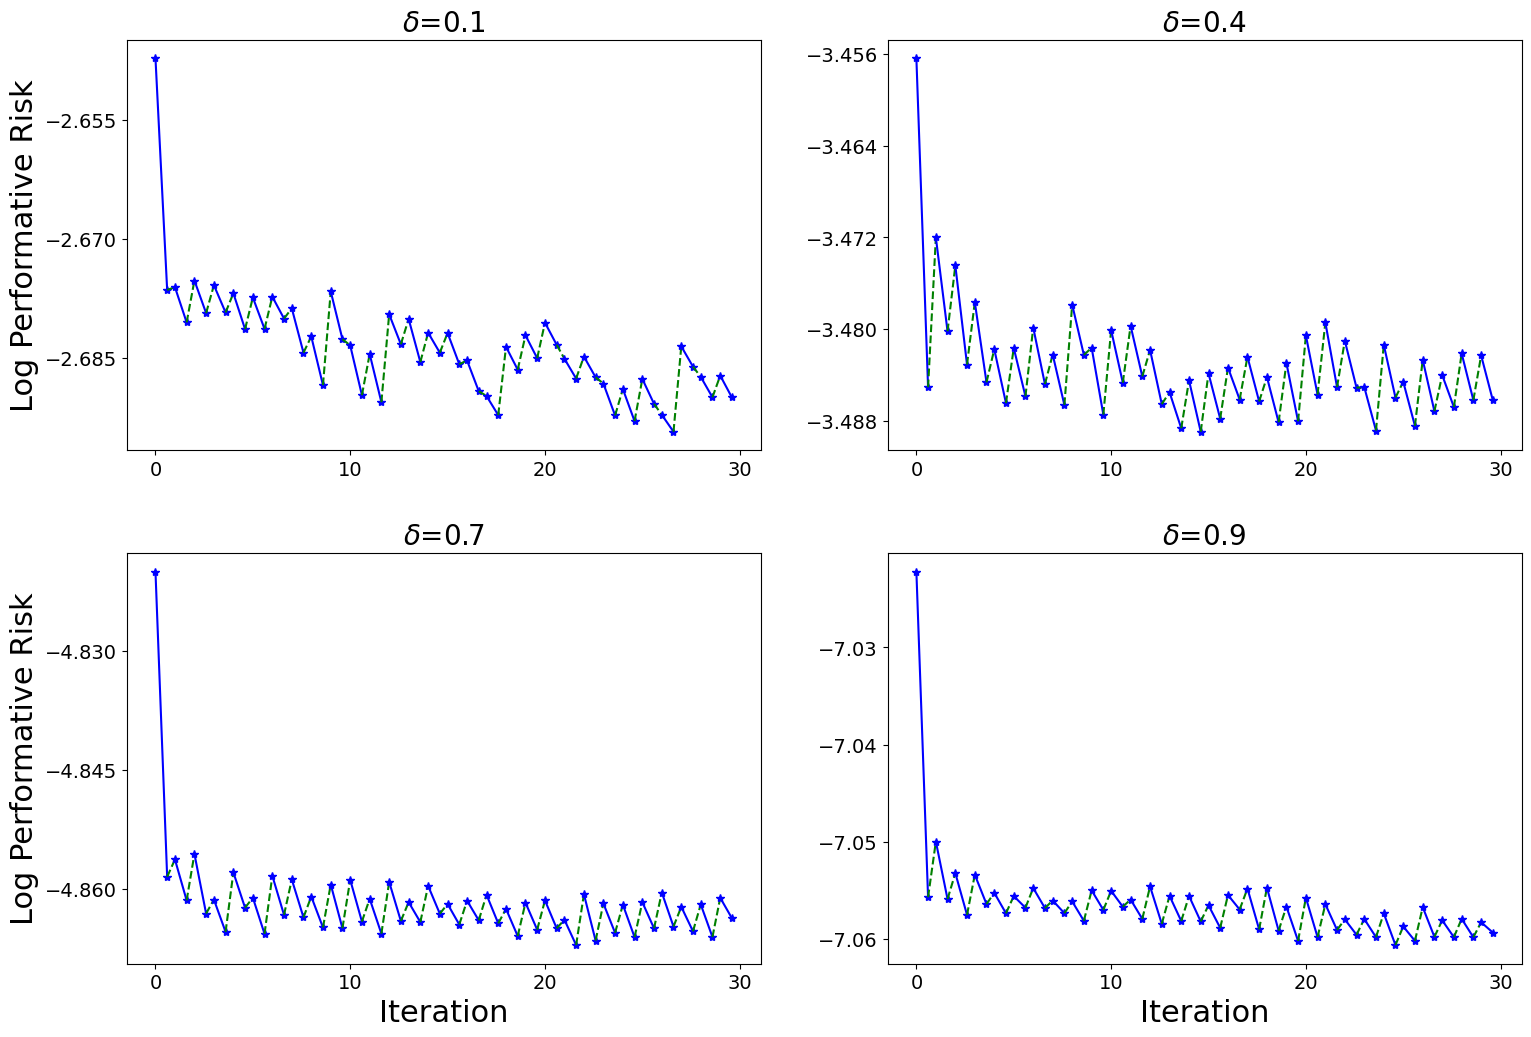

In [ ]:
delta_list = [0.1 , 0.4, 0.7, 0.9]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
loss_starts_log = np.log(np.array(loss_starts))
loss_ends_log = np.log(np.array(loss_ends))

for idx, epsilon in enumerate(delta_list):
    ax = axes[idx // 2][idx % 2]
    offset = 0.6
    ax.set_title(f"$\delta$={epsilon}", fontsize=20)
#     print(len(loss_starts[idx]))
#     print(num_iters)
    for i in range( 0, num_iters):
        if i==0:
            ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'b*-')
        else: 
            ax.plot([i,i + offset],[loss_starts_log[idx][i], loss_ends_log[idx][i]],'b*-')

        if i < num_iters - 1:
            ax.plot([i + offset, i + 1],[loss_ends_log[idx][i], loss_starts_log[idx][i + 1]],'g--')
                
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        ax.tick_params(axis='both', labelsize=14)
        plt.rcParams['ytick.labelsize']=14
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))

    if idx%2 == 0 :
        ax.set_ylabel("Log Performative Risk", fontsize=22)
    if idx>1:
        ax.set_xlabel("Iteration", fontsize=22)
        
plt.subplots_adjust(hspace=0.25)
# fig.savefig('./Results/Run14/loss_different_delta.png', dpi=300)

### Plot accuracy for different values of delta

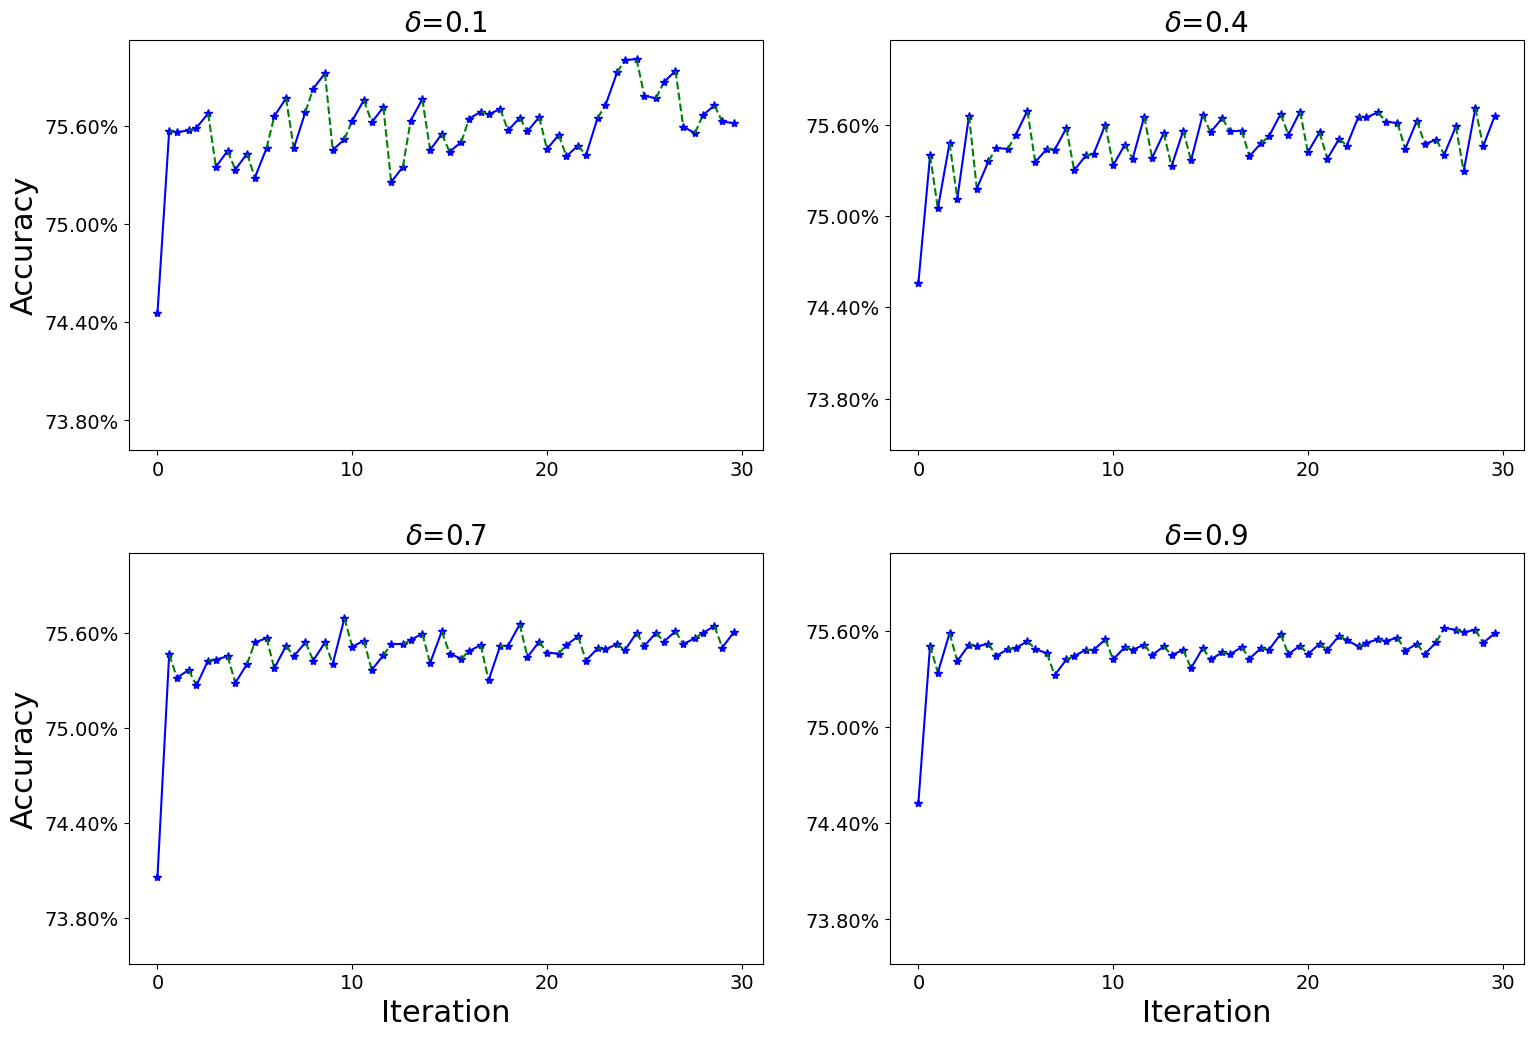

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))


for idx, epsilon in enumerate(delta_list):
#     acc_starts_np = np.array(acc_starts) * 100
#     acc_ends_np = np.array(acc_ends) * 100

    minimum = 100
    maximum = 0
    ax = axes[idx // 2][idx % 2]
    offset = 0.6
    ax.set_title(f"$\delta$={epsilon}", fontsize=20)
    acc_starts_np = np.array(acc_starts) * 100
    acc_ends_np = np.array(acc_ends) * 100

    for i in range(0, num_iters):
        if i==0:
            ax.plot([i,i + offset],[acc_starts_np[idx][i], acc_ends_np[idx][i]],'b*-')
        else:
            ax.plot([i,i + offset],[acc_starts_np[idx][i], acc_ends_np[idx][i]],'b*-')

        if i < num_iters - 1:
            ax.plot([i+offset, i + 1],[acc_ends_np[idx][i], acc_starts_np[idx][i + 1]],'g--')
                    
            
    minimum = min(minimum, acc_starts_np[idx][i])
    minimum = min(minimum, acc_ends_np[idx][i])
    maximum = max(maximum, acc_starts_np[idx][i])
    maximum = max(maximum, acc_ends_np[idx][i])

    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.tick_params(axis='both', labelsize=14)
    plt.rcParams['ytick.labelsize']=14
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    if idx%2 == 0 :
        ax.set_ylabel("Accuracy", fontsize=22)
    if idx>1:
        ax.set_xlabel("Iteration", fontsize=22)

    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_ylim([minimum-2, maximum+0.5])
    plt.subplots_adjust(hspace=0.25)

### Run for different hidden layer sizes and store in loss_starts and loss_ends